In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import requests_cache
import yfinance as yf
import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
sns.set_theme()
device = torch.device("mps")
# device = "cpu"


session = requests_cache.CachedSession("sentiment-model-6.cache")
print(device)

mps


In [18]:
sp500_download = yf.download(
    # pd.read_csv("../data/sp500-firms.csv")["Symbol"].values.tolist(),
    ["TSLA"],
    period="10y",
    interval="1d",
    session=session
)

[*********************100%%**********************]  1 of 1 completed


In [4]:
import pickle as pkl

with open("../data/post-firm-sentiment.pkl", "rb") as f:
    sentiment_df = pkl.load(f)

sentiment_df.set_index("created", inplace=True)
sentiment_df.index = sentiment_df.index.values.astype("datetime64[D]")
sentiment_df.index.name = "Date"
sentiment_df = sentiment_df.rename(columns=lambda x: x.replace("is_", ""))
sentiment_df = sentiment_df.rename(columns={"sentiment_score": "Sentiment"})
sentiment_df = sentiment_df.drop("selftext", axis=1)
sentiment_df = sentiment_df.reset_index()


tickers = sentiment_df.columns.drop(["Date", "Sentiment"])
sentiment_df = sentiment_df.melt(id_vars=["Date", "Sentiment"], var_name="Ticker", value_name="Count")
sentiment_df = sentiment_df[sentiment_df["Count"] == 1].drop("Count", axis=1).reset_index(drop=True)

# for each Ticker, aggregate sentiment by Date (mean)
sentiment_df = sentiment_df.groupby(["Date", "Ticker"]).mean().reset_index()
sentiment_df

,Date,Ticker,Sentiment
0,2021-01-01,A,0.907220
1,2021-01-01,AAL,0.997900
2,2021-01-01,AAPL,0.726300
3,2021-01-01,AMD,0.795900
4,2021-01-01,AMZN,0.726300
...,...,...,...
19274,2021-12-31,TGT,-0.553700
19275,2021-12-31,TMO,0.987300
19276,2021-12-31,TSLA,0.971367
19277,2021-12-31,V,0.984800


In [5]:

sp500_price_df = sp500_download["Close"].fillna(0)
sp500_price_df.index = pd.to_datetime(sp500_price_df.index)
sp500_price_df = sp500_price_df.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Price")
sp500_price_df["Date"] = pd.to_datetime(sp500_price_df['Date'])
sp500_price_df = sp500_price_df[sp500_price_df["Price"] != 0]

sp500_volume_df = sp500_download["Volume"].fillna(0)
sp500_volume_df.index = pd.to_datetime(sp500_volume_df.index)
sp500_volume_df = sp500_volume_df.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Volume")
sp500_volume_df["Date"] = pd.to_datetime(sp500_volume_df['Date'])
sp500_df = sp500_price_df.merge(sp500_volume_df, on=["Date", "Ticker"], how="left").fillna(0)


# sp500_df = sp500_df.merge(sentiment_df, on=["Date", "Ticker"], how="left").fillna(0)
# sp500_df[(sp500_df["Date"] >= "2021-01-01") & (sp500_df["Date"] <= "2021-12-31")]
sp500_df

,Price,Date,Ticker,Volume


Study the following for now:
  - AAPL
  - NVDA
  - WMT
  - V
  - GOOG
  - AMZN
  - MSFT

## AAPL with sentiment

In [59]:
del sp500_download
del sp500_price_df
del sp500_volume_df

/Users/pranav/Projects/cos497/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pranav/Projects/cos497/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pranav/Projects/cos497/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pranav/Projects/cos497/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

<Axes: xlabel='Date', ylabel='Volume'>

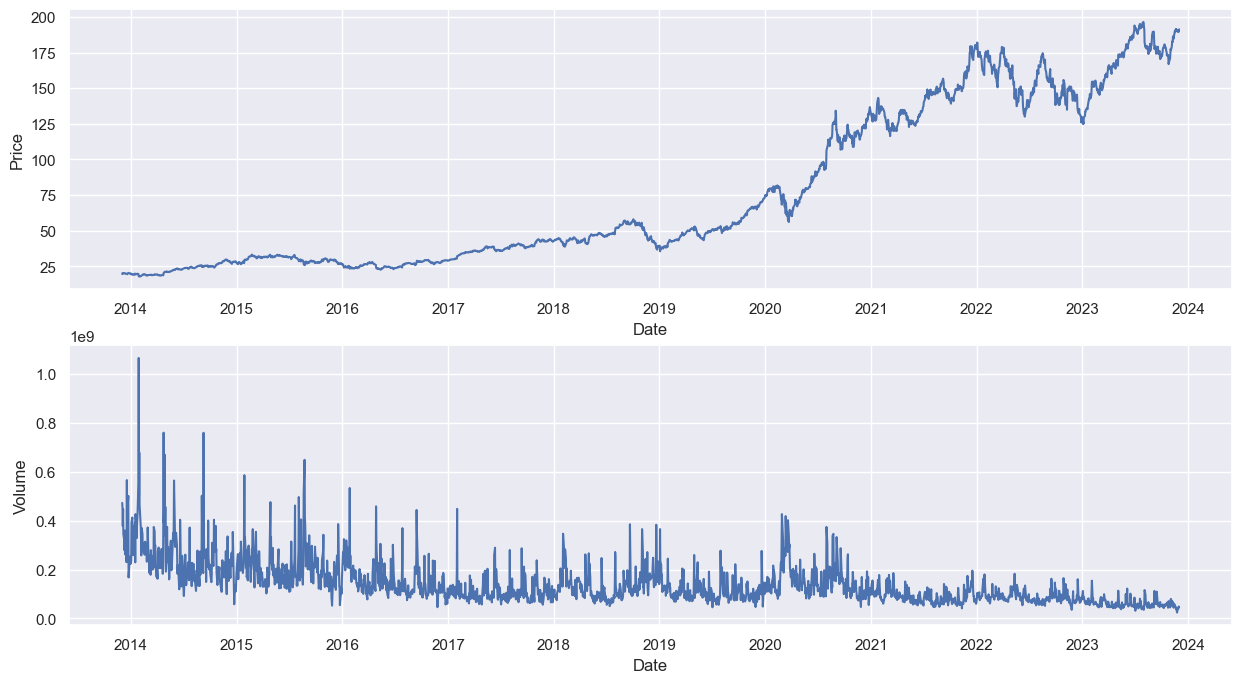

In [60]:
df_aapl = sp500_df
df_aapl = df_aapl[df_aapl["Ticker"] == "AAPL"]
# df_aapl = df_aapl[(df_aapl["Date"] >= "2021-01-01") & (df_aapl["Date"] <= "2021-12-31")].reset_index(drop=True)
df_aapl = df_aapl.set_index("Date")

fig, ax = plt.subplots(2, 1, figsize=(15, 8))
sns.lineplot(data=df_aapl, x="Date", y="Price", ax=ax[0])
sns.lineplot(data=df_aapl, x="Date", y="Volume", ax=ax[1])
# sns.lineplot(data=df_aapl, x="Date", y="Sentiment", ax=ax[2])

In [62]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer

def split_data(df: pd.DataFrame, train_size: float = 0.8, lbp: int = 30, lfp: int = 1):
    """
    lbp: look back period
    lfp: look forward period
    """
    
    train_size = int(len(df) * train_size)
    train = df[:train_size][["Price", "Volume"]]
    train_dates = df[:train_size].index
    test = df[train_size:][["Price", "Volume"]]
    test_dates = df[train_size:].index

    scaler = MinMaxScaler((0, 1))
    ct = ColumnTransformer([("scaler", scaler, ["Price", "Volume"])], remainder="passthrough")

    train_scaled = ct.fit_transform(train)
    test_scaled = ct.transform(test)

    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for i in range(lbp, train_scaled.shape[0] - lfp + 1):
        X_train.append(train_scaled[i - lbp:i, :])
        y_train.append(train_scaled[i:i + lfp, 0])

    for i in range(lbp, test_scaled.shape[0] - lfp + 1):
        X_test.append(test_scaled[i - lbp:i, :])
        y_test.append(test_scaled[i:i + lfp, 0])
    
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    SUBSAMPLE = False
    subsample_ratio = 0.01
    if SUBSAMPLE:
        size = int(X_train.shape[0] * subsample_ratio)
        X_train = X_train[:size]
        y_train = y_train[:size]
        
        size = int(X_test.shape[0] * subsample_ratio)
        X_test = X_test[:size]
        y_test = y_test[:size]

    return X_train, y_train, train_dates, X_test, y_test, test_dates, ct

train_size = 0.9
lookback_period = 60
lookforward_period = 1
X_train, y_train, train_dates, X_test, y_test, test_dates, scaler = split_data(sp500_df, train_size=train_size, lbp=lookback_period, lfp=lookforward_period)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

X_train shape: (1108408, 60, 2)
y_train shape: (1108408, 1)
X_test shape: (123104, 60, 2)
y_test shape: (123104, 1)


- Axis 0: Sample (window) dimension
- Axis 1: Time dimension (within window)
- Axis 2: Feature dimension (0 = price, 1 = sentiment)

In [76]:
input_size = 2 # num channels in input
num_layers = 2 # num of hidden layers
hidden_size = 32 # num of hidden nodes in each layer
output_size = lookforward_period # timesteps to predict

In [77]:
class LSTMModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, output_size)
    
    def forward(self, x: torch.Tensor):
        out, _ = self.lstm(x)
        out = self.fc_out(out[:, -1, :])
        return out

In [111]:
from torch.utils.data import TensorDataset, DataLoader

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

print(model)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# now that input windows are no longer grouped by company, we can shuffle the data
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

LSTMModel(
  (lstm): LSTM(2, 32, num_layers=2, batch_first=True)
  (fc_out): Linear(in_features=32, out_features=1, bias=True)
)


In [112]:
from tqdm.notebook import tqdm, trange

num_epochs = 100
train_hist = np.zeros((num_epochs,))
test_hist = np.zeros((num_epochs,))

progress_bar = trange(num_epochs, desc="Epochs", postfix={"train_loss": 0.0, "test_loss": 0.0})
train_bar = tqdm(total=len(train_loader), desc="Training", leave=True)
test_bar = tqdm(total=len(test_loader), desc="Testing", leave=True)

for epoch in progress_bar:
    epoch_loss = 0.0

    # reset the progress bars
    train_bar.reset()
    test_bar.reset()

    # training loop
    model.train()
    for batch_X, batch_y in train_loader:
        # tick the progress bar
        train_bar.update()

        # forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    train_bar.refresh()
    train_hist[epoch] = epoch_loss / len(train_loader)

    # testing loop
    model.eval()
    with torch.no_grad():
        epoch_loss = 0.0

        for batch_X, batch_y in test_loader:
            # tick the progress bar
            test_bar.update()

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            y_pred = model(batch_X)
            loss = loss_fn(y_pred, batch_y)

            epoch_loss += loss.item()
        
        test_bar.refresh()
        test_hist[epoch] = epoch_loss / len(test_loader)

    
    # print stats
    # print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_hist[-1]} | Test Loss: {test_hist[-1]}")

    # update progress bar
    progress_bar.postfix = {"train_loss": float(f"{train_hist[epoch]:.6f}"), "test_loss": float(f"{test_hist[epoch]:.6f}")}

# close progress bars
train_bar.close()
test_bar.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s, test_loss=0, train_loss=0]

Training:   0%|          | 0/4330 [00:00<?, ?it/s]

Testing:   0%|          | 0/481 [00:00<?, ?it/s]

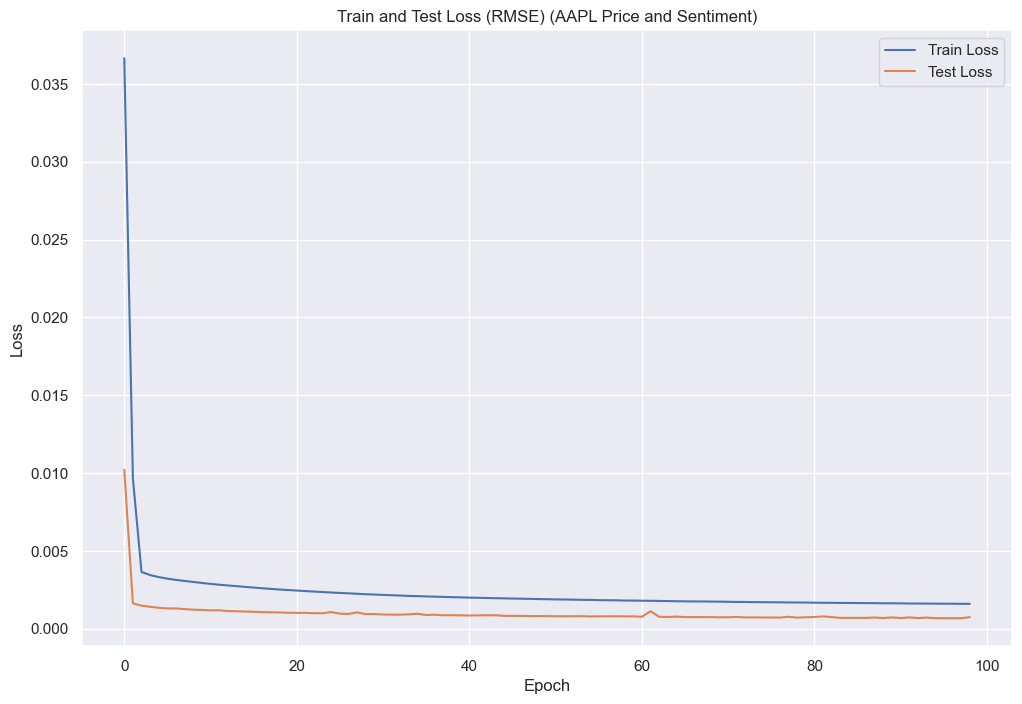

In [113]:
# plot train and test loss
train_hist = np.array(train_hist)
test_hist = np.array(test_hist)

train_rmse = np.sqrt(train_hist)
test_rmse = np.sqrt(test_hist)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train_rmse[:epoch], label="Train Loss")
ax.plot(test_rmse[:epoch], label="Test Loss")
ax.set_title("Train and Test Loss (RMSE) (AAPL Price and Sentiment)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

In [114]:
train_rmse[epoch - 1], test_rmse[epoch - 1]

(0.0016059743913201972, 0.0007503687781260567)

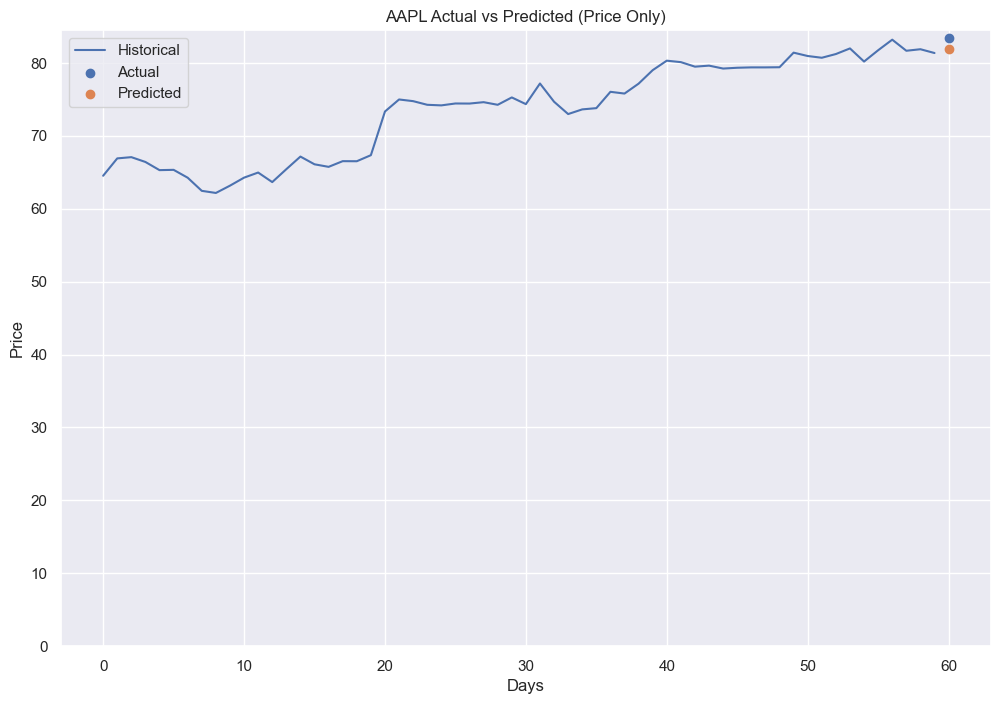

In [115]:
X = X_test.cpu().numpy()
y = y_test
sample = np.random.randint(0, len(X))
# sample = 0

X_sample = X[sample]
y_sample = y[sample].cpu().numpy()

with torch.no_grad():
    model.eval()
    y_pred = model(torch.from_numpy(X_sample.reshape(1, lookback_period, input_size)).float().to(device)).cpu().numpy()[0]


actual = scaler.transformers_[0][1].inverse_transform(X_sample.reshape(-1, input_size))
historical = actual[:, 0]
# print(f"Actual Price: {actual_future[sample][0]}")
# print(f"Predicted Price: {predicted_future[sample][0]}")

actual_future = np.zeros((lookforward_period, input_size))
actual_future[:, 0] = y_sample
actual_future = scaler.transformers_[0][1].inverse_transform(actual_future)[:, 0]

predicted_future = np.zeros((lookforward_period, input_size))
predicted_future[:, 0] = y_pred
predicted_future = scaler.transformers_[0][1].inverse_transform(predicted_future)[:, 0]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(historical, label="Historical")
# ax.plot(range(lookback_period, lookback_period + lookforward_period), actual_future, label="Actual")
# ax.plot(range(lookback_period, lookback_period + lookforward_period), predicted_future, label="Predicted")
ax.scatter(lookback_period, actual_future, label="Actual")
ax.scatter(lookback_period, predicted_future, label="Predicted")
ax.set_title("AAPL Actual vs Predicted (Price Only)")
ax.set_xlabel("Days")
ax.set_ylabel("Price")
ax.set_ylim(bottom=0)
ax.legend()

In [105]:
X_test.cpu().numpy()[:50].shape

(50, 60, 2)

In [128]:
X_test_final = X_test.cpu().numpy()[0:200]
y_test_final = y_test.cpu().numpy()[0:200]

/Users/pranav/Projects/cos497/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pranav/Projects/cos497/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pranav/Projects/cos497/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pranav/Projects/cos497/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

(0.0, 0.020763643179088832)

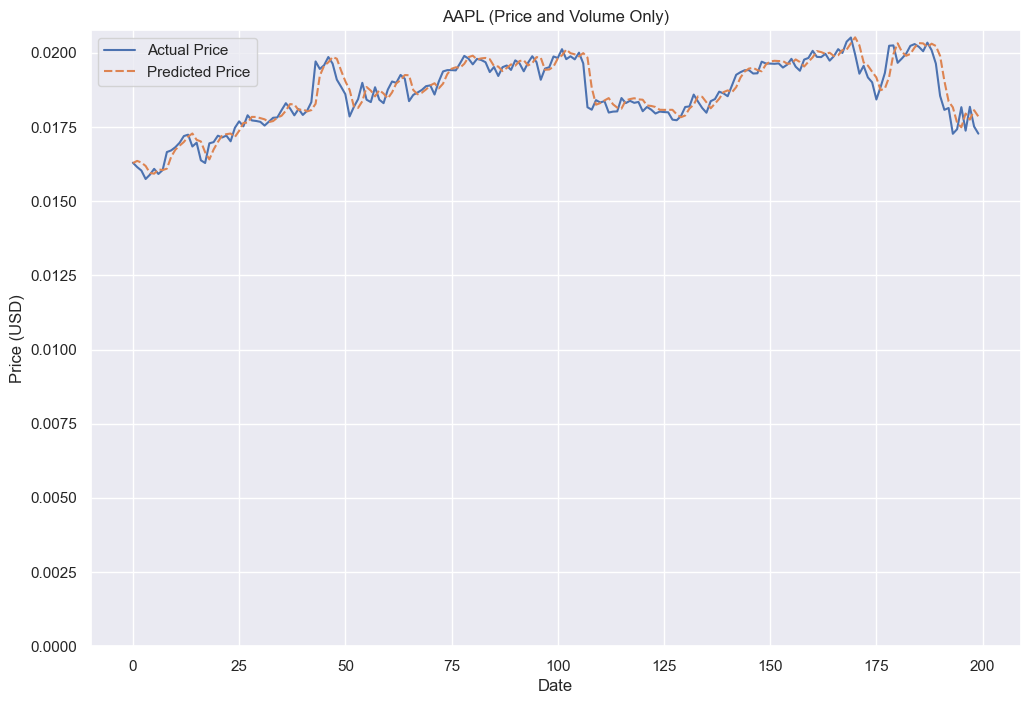

In [129]:
y_pred = []

with torch.no_grad():
    model.eval()
    for X in X_test_final:
        y_pred.append(model(torch.from_numpy(X.reshape(1, lookback_period, input_size)).float().to(device)).cpu().numpy()[0])

y_pred = np.array(y_pred).reshape(-1)

pred_df = pd.DataFrame({
    "Actual Price": y_test_final.reshape(-1),
    "Predicted Price": y_pred.reshape(-1),
})

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.lineplot(data=pred_df, ax=ax)
ax.set_xticks(np.arange(len(pred_df)), minor=True)
ax.set_title("AAPL (Price and Volume Only)")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.set_ylim(bottom=0)